In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from utils import (genrate_data, MLE_MAP, PolynomialFeature, plot_results,
                   Trainer, NpDataset, plot_DB, plot_DR, Least_Squares)

## Regression

In [2]:
N = 50
def f(x): return np.sin(2 * np.pi * x)
X_train, y_train, X_test, y_test = genrate_data(f, N_tr=N, l=0, h=1, std=0.05)

### GLM

In [3]:
degree = 4
mu = np.linspace(1, 0, degree)
s = 0.05
glm_R = MLE_MAP(basis='Gauss', b_mu=mu, b_s=s)
glm_R.fit(X_train, y_train, scale=False)
glm_pred = glm_R.predict(X_test)

### NN

In [4]:
class NN(nn.Module):
    def __init__(self, reg_cls, act, num_layers, neurons=10, in_dim=1, out_dim=1):
        super(NN, self).__init__()
        self.reg_cls = reg_cls.lower()
        layers = [nn.Linear(in_dim, neurons), act()]+\
                 [nn.Linear(neurons, neurons), act()]*num_layers+\
                 [nn.Linear(neurons, out_dim)]
        self.model = nn.Sequential(*layers)
        self.sigmoid = nn.Softmax()
        
    def forward(self, x):
        return self.model(x) if self.reg_cls == 'regression' else self.sigmoid(self.model(x))

In [6]:
# initiate the model
NN_R = NN('Regression', nn.Tanh, 5, 15)
# MSE loss function
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(NN_R.parameters(), lr=0.02)

In [7]:
# training pytorch dataloader
data = DataLoader(NpDataset(X_train, y_train), batch_size=10)

In [8]:
# Define model trainer and start training 
model_trainer_R = Trainer(NN_R, optimizer, criterion, 150)
model_trainer_R.run(data)

Epoch 68/150, Loss: 0.1087, lr=0.02: 100%|██████████████████████████████████████████████| 5/5 [00:00<00:00, 125.07it/s]


Epoch 136/150, Loss: 0.0133, lr=0.02: 100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 135.22it/s]


Epoch 150/150, Loss: 0.0744, lr=0.02: 100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 156.34it/s]


In [9]:
NN_R_pred = NN_R(torch.from_numpy(X_test).float()).detach().numpy().flatten()

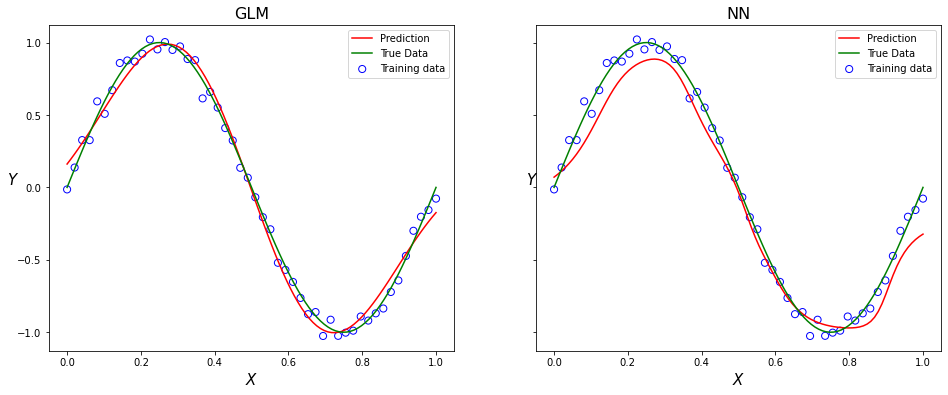

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

plot_results(X_train, y_train, X_test, y_test, glm_pred, axes[0], true_label='True Data', 
             pred_label='Prediction', label='Training data', title='GLM')

plot_results(X_train, y_train, X_test, y_test, NN_R_pred, axes[1], true_label='True Data', 
             pred_label='Prediction', label='Training data', title='NN');